In [1]:
import matplotlib.pyplot as plt
import pandas as pd

import pdfplumber

from collections import Counter
import re

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords, brown
from nltk.stem.wordnet import WordNetLemmatizer
import spacy

from textblob import TextBlob

from tqdm import trange
import requests
from bs4 import BeautifulSoup

In [2]:
eng_stopwords = stopwords.words("english")
Tokenizer = RegexpTokenizer(r"[A-Za-z0-9-]+")
wl=WordNetLemmatizer()
nlp = spacy.load('en_core_web_lg')

## Preparing data

In [3]:
pages = []
with pdfplumber.open("KG.pdf") as pdf:
    for i in trange(12, 273):
        pages.append(pdf.pages[i].extract_text())

100%|████████████████████████████████████████████████████████████████████████████████| 261/261 [00:31<00:00,  8.40it/s]


In [4]:
letter = 'A'
chapter = ''
chapters = []
for page in pages:
    if page[:6].replace('\n', '').replace(' ', '') == letter:
        chapters.append(chapter)
        chapter = ''
        letter = chr(ord(letter) + 1)     
    else:
        chapter += page
        
    if page == pages[-1]:
        chapters.append(chapter)
        
chapters = chapters[1:]

In [5]:
pages = [page.replace('\n', '') for page in pages]
chapters = [chapter.replace('\n', '') for chapter in chapters]
all_text = ' '.join(pages)
all_sentences = nltk.tokenize.sent_tokenize(all_text)

In [6]:
f'Number of chapters (one for each letter): {len(chapters)}, number of pages: {len(pages)}'

'Number of chapters (one for each letter): 26, number of pages: 261'

## Number of characters

In [7]:
counter = dict(Counter(re.sub('[^a-z]', '', all_text.lower())))
counter = dict(sorted(counter.items(), key=lambda item: item[0]))

Text(0.5, 1.0, '...')

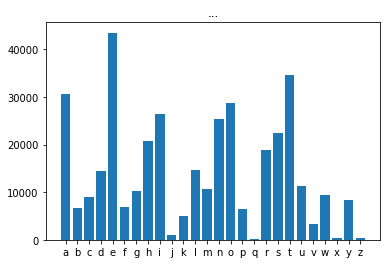

In [8]:
plt.bar(range(len(counter)), list(counter.values()), align='center')
plt.xticks(range(len(counter)), list(counter.keys()))
plt.title('...')

## Number of words per one page

In [9]:
number_of_words = []
for i in range(len(pages)):
    words = pages[i].split(' ')
    words = [word for word in words if word != '']
    number_of_words.append(len(words))

(array([17., 16.,  5.,  3.,  1.,  1.,  4.,  3.,  9.,  4.,  7.,  4.,  3.,
         2., 10.,  7., 11.,  8., 13.,  7.,  5.,  7., 14.,  2.,  4., 12.,
        12.,  5.,  4.,  8., 13.,  3.,  8.,  5.,  4., 11.,  2.,  5.,  1.,
         1.]),
 array([  0.  ,  17.75,  35.5 ,  53.25,  71.  ,  88.75, 106.5 , 124.25,
        142.  , 159.75, 177.5 , 195.25, 213.  , 230.75, 248.5 , 266.25,
        284.  , 301.75, 319.5 , 337.25, 355.  , 372.75, 390.5 , 408.25,
        426.  , 443.75, 461.5 , 479.25, 497.  , 514.75, 532.5 , 550.25,
        568.  , 585.75, 603.5 , 621.25, 639.  , 656.75, 674.5 , 692.25,
        710.  ]),
 <BarContainer object of 40 artists>)

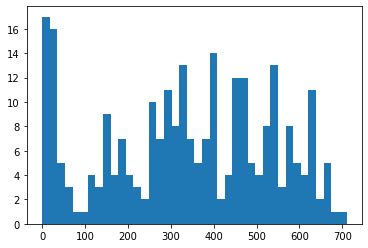

In [10]:
plt.hist(number_of_words, bins=40)

## Number of sentences per one page

In [11]:
number_of_sentences = []
for i in range(len(pages)):
    sentences = pages[i].replace(' ', '').split('.')
    sentences = [sentence for sentence in sentences if sentence != '']
    if len(sentences) > 1:      
        number_of_sentences.append(len(sentences))

(array([ 9.,  3.,  0.,  1.,  7.,  7.,  7.,  6.,  6., 10., 10.,  4.,  4.,
        16., 17.,  9., 13.,  5.,  9.,  4.,  6.,  8.,  7.,  8.,  4.,  4.,
         8.,  3.,  5., 12.,  5.,  2.,  4.,  2.,  2.,  2.,  0.,  1.,  0.,
         2.]),
 array([ 2.   ,  4.075,  6.15 ,  8.225, 10.3  , 12.375, 14.45 , 16.525,
        18.6  , 20.675, 22.75 , 24.825, 26.9  , 28.975, 31.05 , 33.125,
        35.2  , 37.275, 39.35 , 41.425, 43.5  , 45.575, 47.65 , 49.725,
        51.8  , 53.875, 55.95 , 58.025, 60.1  , 62.175, 64.25 , 66.325,
        68.4  , 70.475, 72.55 , 74.625, 76.7  , 78.775, 80.85 , 82.925,
        85.   ]),
 <BarContainer object of 40 artists>)

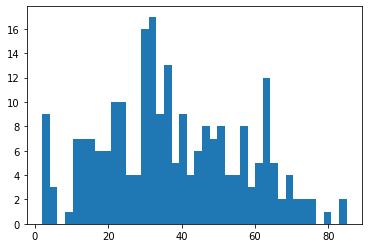

In [12]:
plt.hist(number_of_sentences, bins=40)

## The most common words used in the book

In [13]:
def finding_words(all_text):
    words = all_text.split(' ')
    words = [word for word in words if word != '']
    cleaned_words = []
    for word in words:
        word = word.lower()
        word = Tokenizer.tokenize(word)  
        if len(word) > 0:
            word = [wl.lemmatize(word[0], 'v')]
            word = word if word[0] not in eng_stopwords else ['']
            word = word if len(word[0])>2 else ['']
            
            cleaned_words.append(word[0])

    cleaned_words = [word for word in cleaned_words if word != ['']]
    cleaned_words = [word for word in cleaned_words if word != '']
    
    return cleaned_words

In [14]:
def find_the_most_common_words(comments, limit=15):
    x = Counter(comments).most_common()[:limit]
    words = list(zip(*x))[0]
    occurrences = list(zip(*x))[1]
    
    return words, occurrences

In [15]:
cleaned_words = finding_words(all_text)

In [16]:
words, occurrences = find_the_most_common_words(cleaned_words, limit=15)

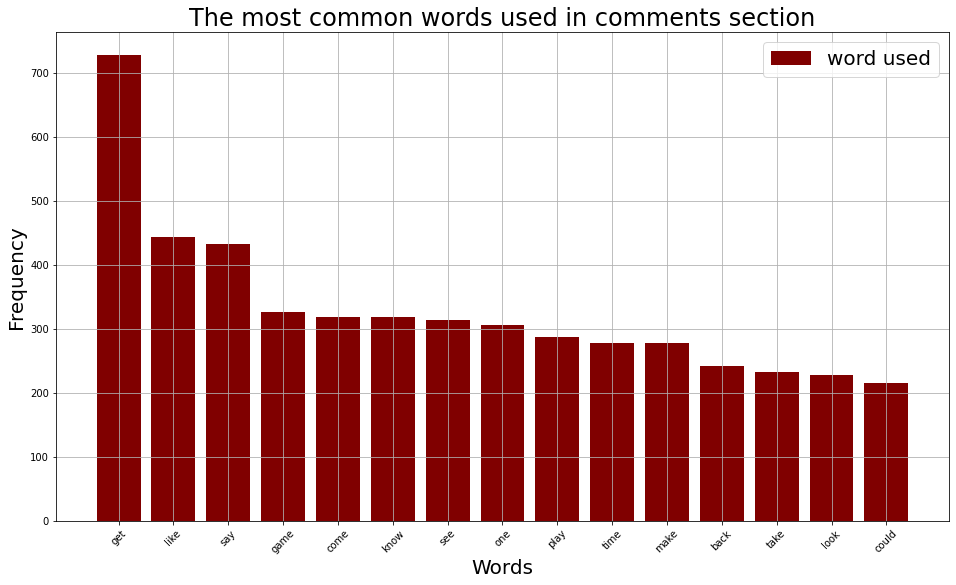

In [17]:
plt.figure(figsize=(16, 9))
plt.title('The most common words used in comments section', fontsize=24)
plt.xlabel('Words', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.bar(words, occurrences, color='maroon')
plt.legend(['word used'], prop={'size': 20})
plt.xticks(rotation=45)
plt.grid()

## How often do the most common words appear in a single chapter?

In [18]:
top_five = list(words[:5])

In [19]:
counters_for_words = []
for word in top_five:
    counters = []
    for chapter in chapters:
        counters.append(finding_words(chapter).count(word))
        
    counters_for_words.append(counters)

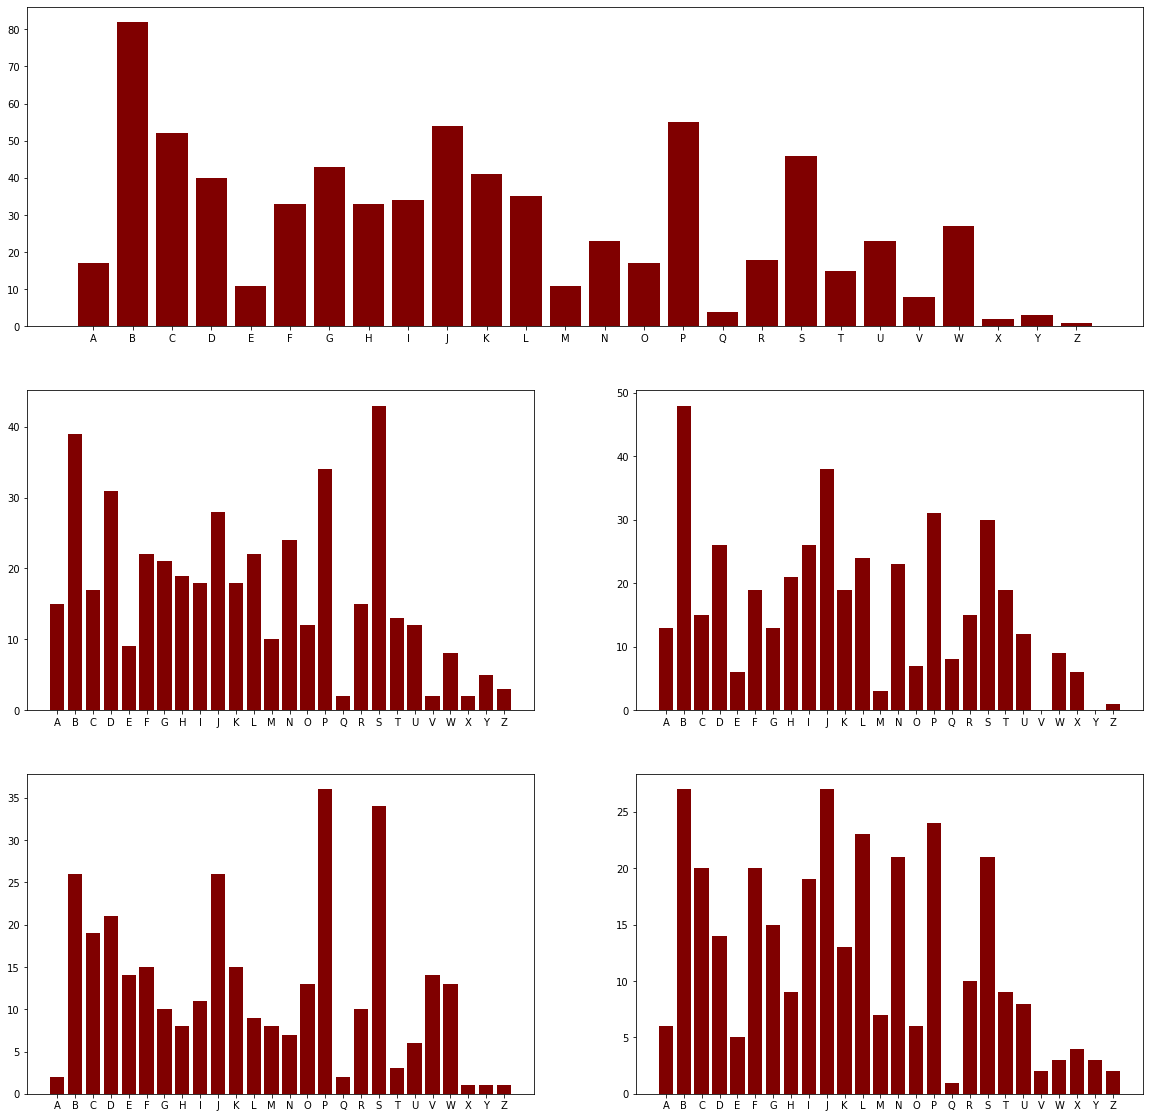

In [20]:
plt.figure(figsize=(20, 20))
for i in range(len(top_five)):
    if i == 0:
        plt.subplot(3, 1, i+1)
    else:
        plt.subplot(3, 2, i+2)
    plt.bar([chr(j) for j in range(65, 91)], counters_for_words[i], color='maroon')

## The most common noun phrases used in the book

-> maybe RegexpParser is better? - to check

In [21]:
def finding_noun_phrases(comments):
    noun_phrases_comments = []
    cleaned_comments = []
    wl=WordNetLemmatizer()
    for comment in comments:
        comment = comment.lower()
        comment = Tokenizer.tokenize(comment)
        comment = [word for word in comment if word not in eng_stopwords]
        comment = [word for word in comment if len(word)>2] 
        comment = " ".join(comment)
        comment = TextBlob(comment)
        comment = comment.noun_phrases   
        noun_phrases_comments.append(comment)

    noun_phrases_comments_combined = [word for sublist in noun_phrases_comments for word in sublist]
    
    return noun_phrases_comments_combined

In [22]:
def find_the_most_common_noun_phrases(comments, limit=15):
    x = Counter(comments).most_common()[:limit] 
    x = [phrase for phrase in x if phrase[0] != 'gon na']
    x = [phrase for phrase in x if phrase[0] != 'wan na']
    x = [phrase for phrase in x if len(phrase[0].split(' '))==2]
    words = list(zip(*x))[0]
    occurrences = list(zip(*x))[1]
    
    return words, occurrences

In [23]:
words, occurrences = find_the_most_common_noun_phrases(finding_noun_phrases(chapters))

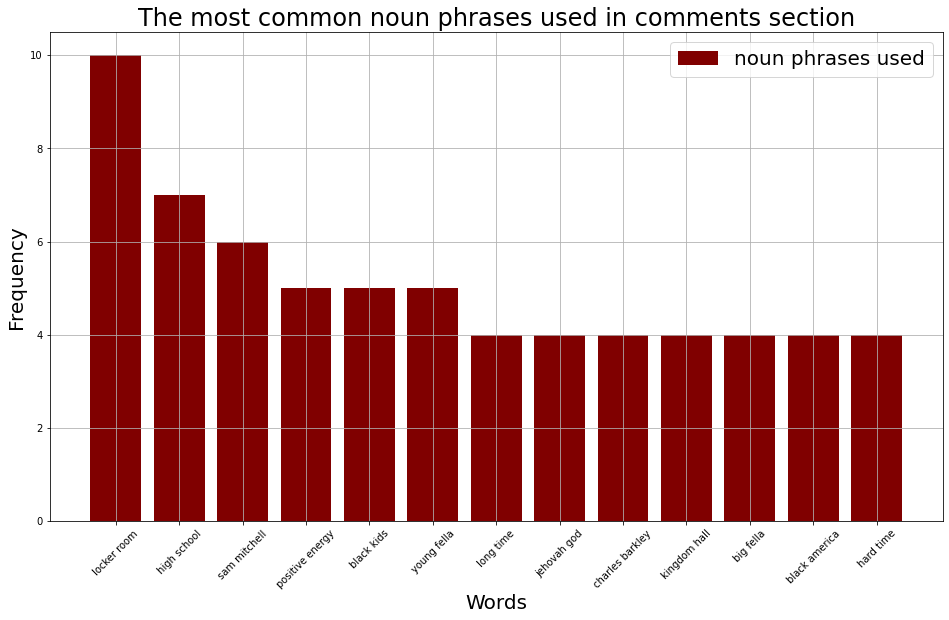

In [24]:
plt.figure(figsize=(16, 9))
plt.title('The most common noun phrases used in comments section', fontsize=24)
plt.xlabel('Words', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.bar(words, occurrences, color='maroon')
plt.legend(['noun phrases used'], prop={'size': 20})
plt.xticks(rotation=45)
plt.grid()

In [25]:
len(all_sentences)

8218

## Top words in each category of part of the speech

Spacy POS description: https://machinelearningknowledge.ai/tutorial-on-spacy-part-of-speech-pos-tagging/

In [26]:
POS = ['PRON', 'VERB', 'DET', 'NOUN', 'ADP', 'ADJ', 'PUNCT', 'ADV', 'NUM']
for item in POS:
    print(f"{item}: {spacy.explain(item)}")

PRON: pronoun
VERB: verb
DET: determiner
NOUN: noun
ADP: adposition
ADJ: adjective
PUNCT: punctuation
ADV: adverb
NUM: numeral


In [27]:
spacy_pos_tagged = []
for sentence in all_sentences:
    spacy_pos_tagged.extend([(word, word.pos_) for word in nlp(sentence)])

In [28]:
def get_pos_tag(words, tag, limit):
    pos_tag_words = []
    for word_tag in words:
        if word_tag[1] == tag:
            if word_tag[1] == 'VERB':            
                word = wl.lemmatize(str(word_tag[0]), 'v')          
            else:
                word = word_tag[0]
            if str(word) != '’s' and str(word) != '’m':
                pos_tag_words.append(str(word).lower())
    
    most_common = Counter(pos_tag_words).most_common()[:limit]
                 
    return most_common

In [29]:
for item in POS:
    print(item, get_pos_tag(spacy_pos_tagged, item, 15), '\n')

PRON [('i', 3091), ('you', 1123), ('it', 1069), ('he', 1034), ('my', 934), ('me', 870), ('that', 637), ('we', 533), ('his', 506), ('they', 393), ('him', 308), ('who', 290), ('what', 269), ('your', 254), ('us', 177)] 

VERB [('get', 705), ('have', 546), ('go', 438), ('say', 429), ('do', 357), ('come', 319), ('know', 314), ('see', 313), ('make', 263), ('play', 259), ('take', 219), ('look', 202), ('want', 178), ('give', 158), ('think', 145)] 

DET [('the', 4252), ('a', 1890), ('that', 339), ('all', 205), ('no', 195), ('an', 172), ('this', 170), ('some', 139), ('those', 128), ('every', 94), ('another', 68), ('these', 65), ('any', 44), ('each', 33), ('both', 11)] 

NOUN [('time', 256), ('game', 228), ('way', 160), ('shit', 137), ('life', 121), ('team', 117), ('man', 106), ('league', 102), ('brothas', 98), ('years', 96), ('thing', 92), ('players', 90), ('people', 85), ('year', 84), ('world', 84)] 

ADP [('in', 1377), ('of', 1347), ('to', 945), ('on', 635), ('with', 613), ('for', 548), ('up',

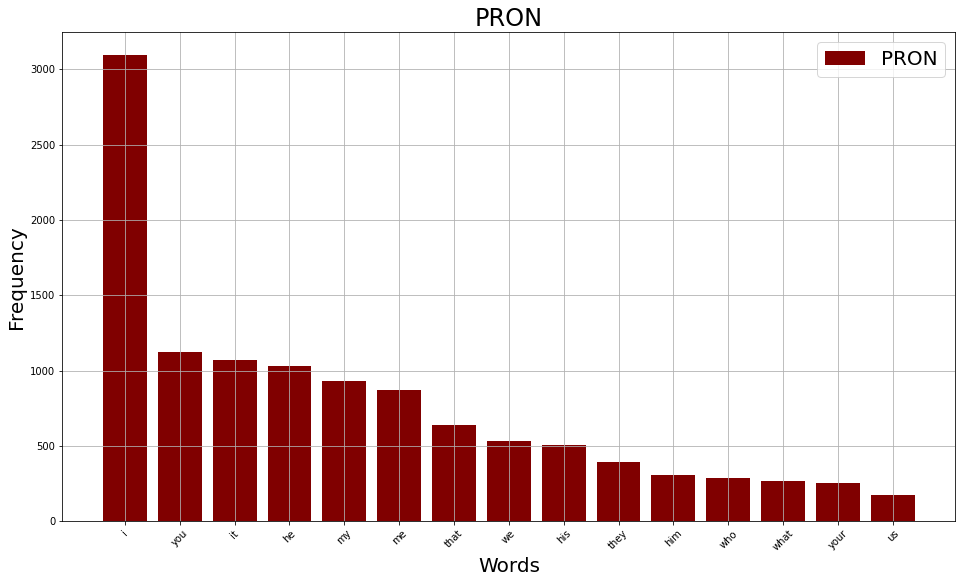

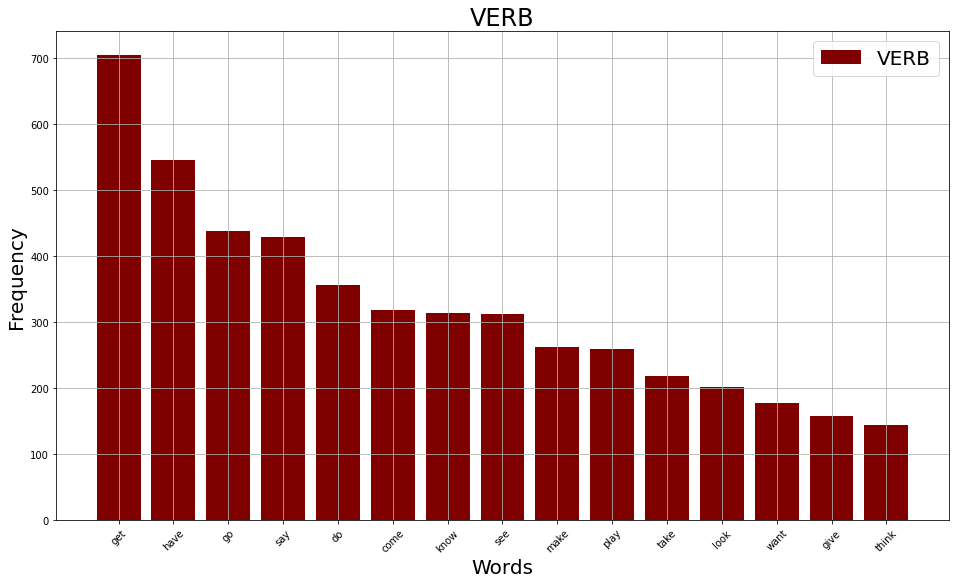

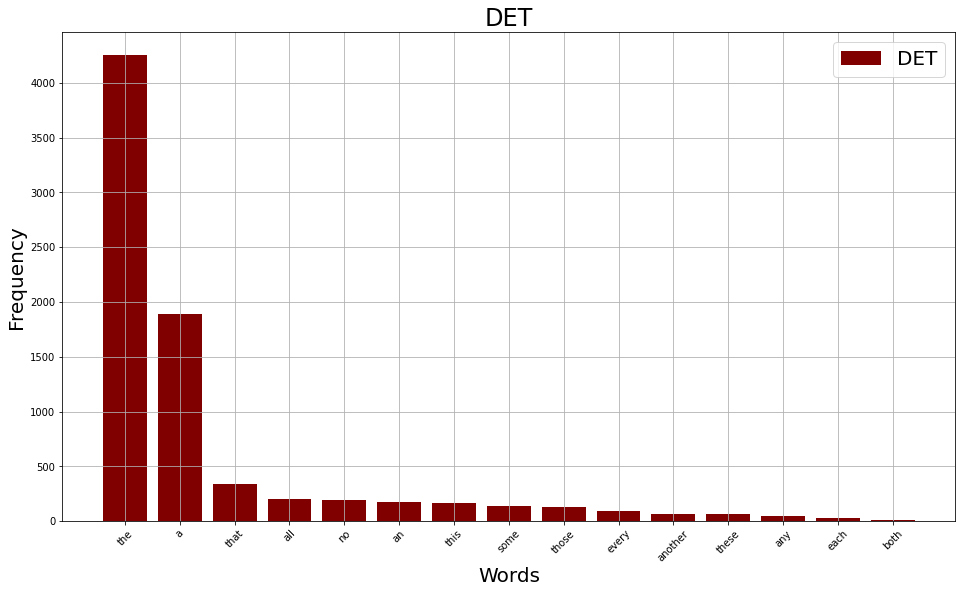

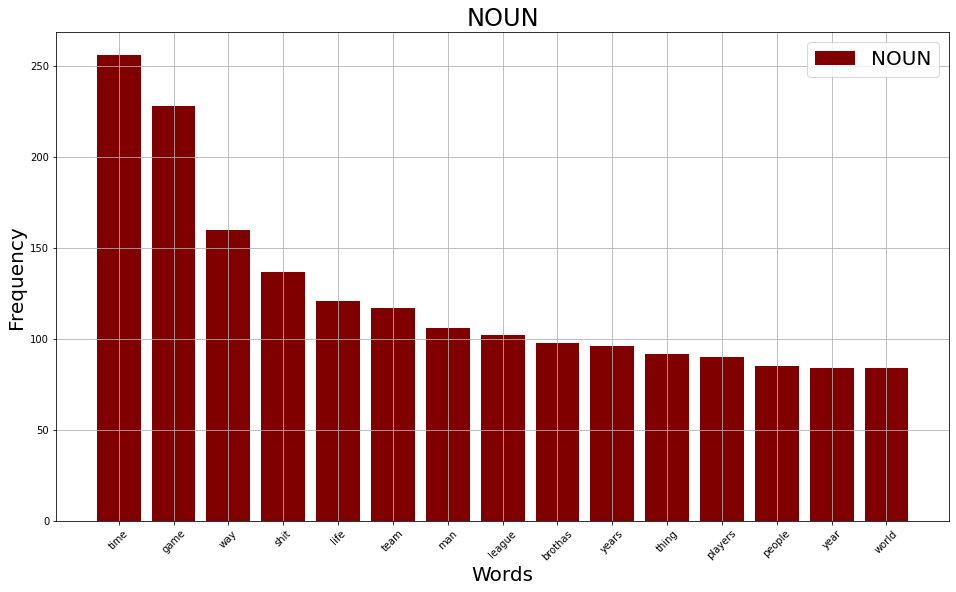

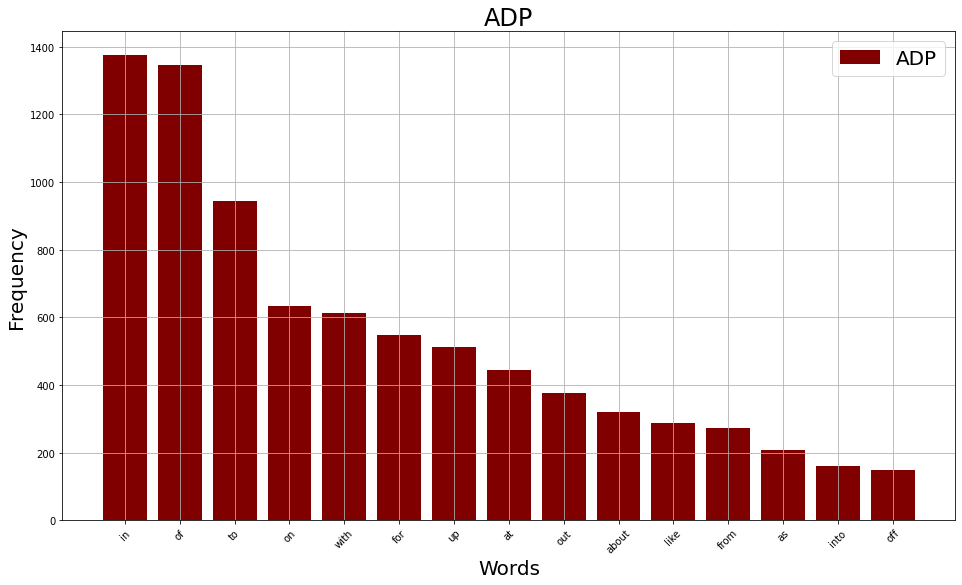

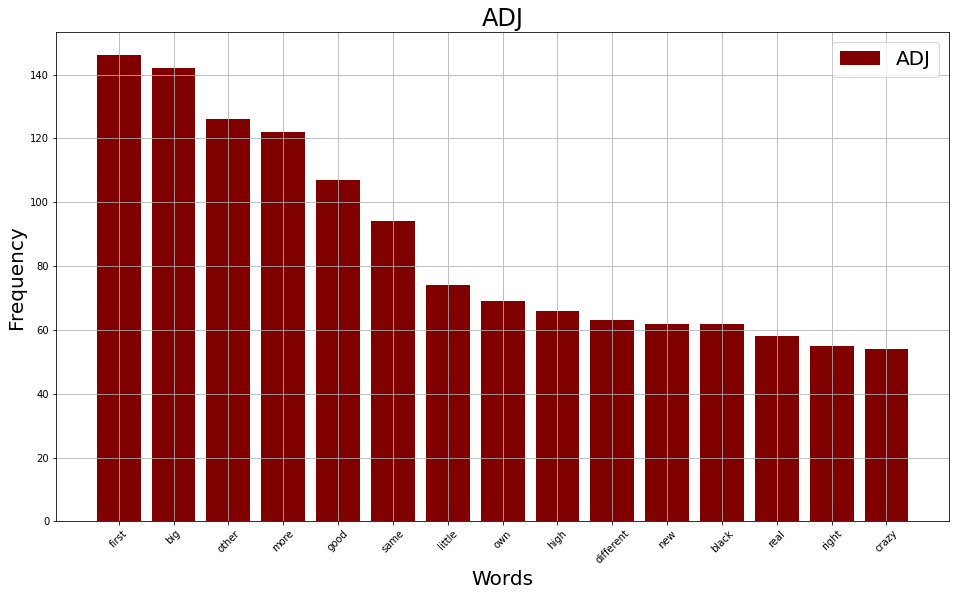

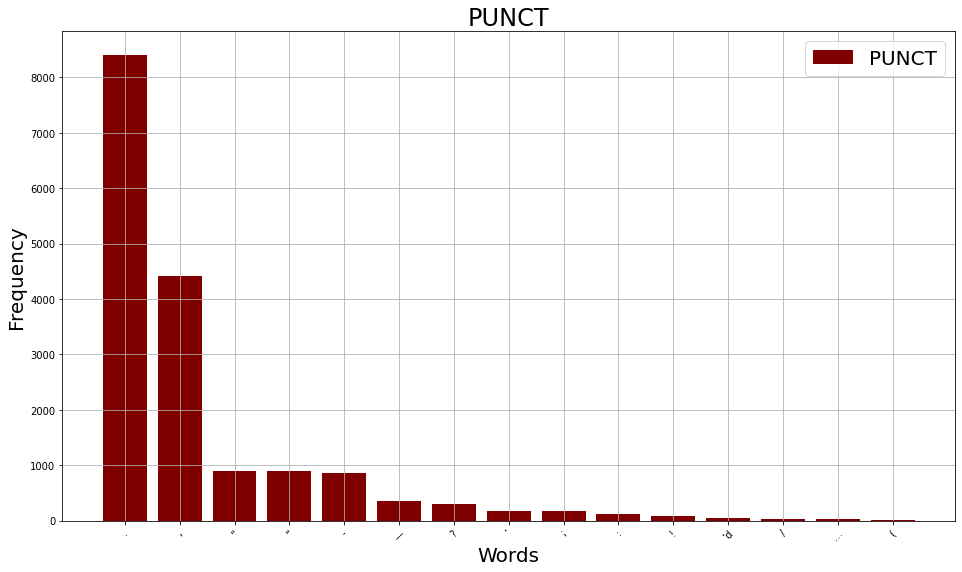

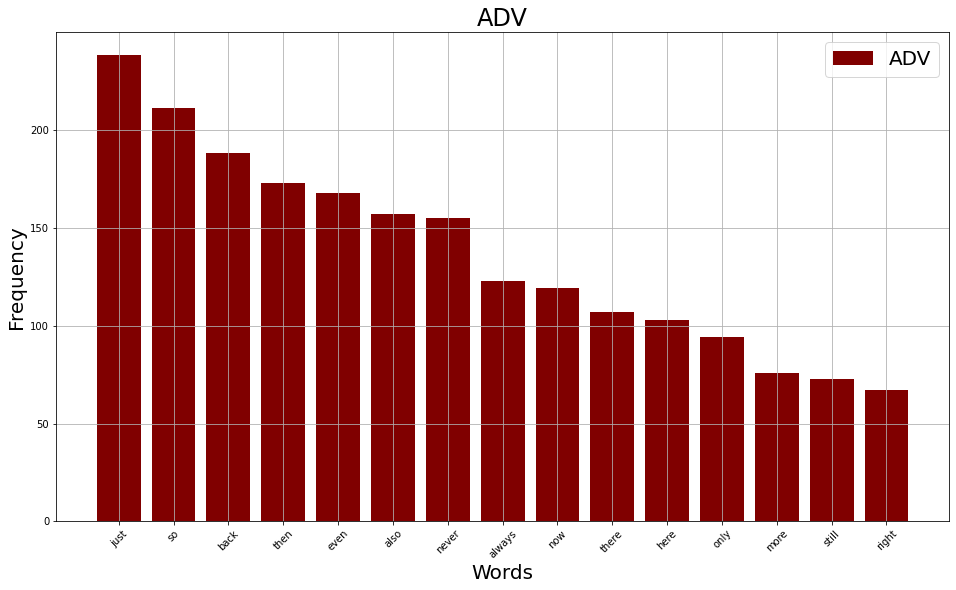

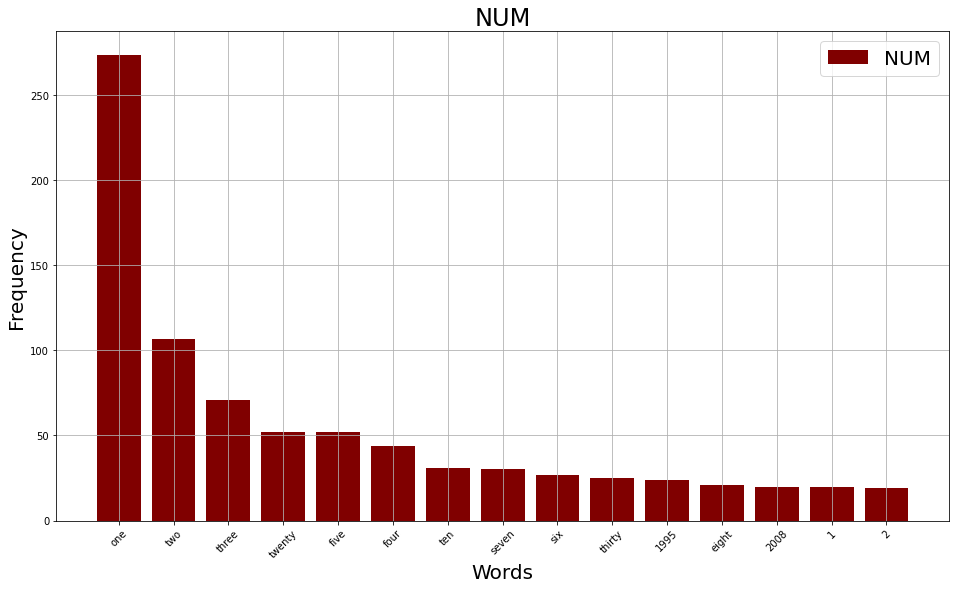

In [30]:
for item in POS:
    most_common = get_pos_tag(spacy_pos_tagged, item, 15)
    words = list(zip(*most_common))[0]
    occurrences = list(zip(*most_common))[1]
    plt.figure(figsize=(16, 9))
    plt.title(item, fontsize=24)
    plt.xlabel('Words', fontsize=20)
    plt.ylabel('Frequency', fontsize=20)
    plt.bar(words, occurrences, color='maroon')
    plt.legend([item], prop={'size': 20})
    plt.xticks(rotation=45)
    plt.grid()

## Finding names of basketball players

In [31]:
def get_human_names(text):
    """
    Finds all names and surnames in a book using nltk library
    
    Input:
        text: str - a single chapter of a book "Around the world in 80 days"
        
    Output:
        person_list: list - list of words classified as a city    
    """
    tokens = nltk.tokenize.word_tokenize(text)
    pos = nltk.pos_tag(tokens)
    sentt = nltk.ne_chunk(pos, binary = False)
    person_list = []
    person = []
    name = ""
    for subtree in sentt.subtrees(filter=lambda t: t.label() == 'PERSON'):
        for leaf in subtree.leaves():
            person.append(leaf[0])
        if len(person) > 1:
            for part in person:
                name += part + ' '
            person_list.append(name[:-1])
            name = ''
        person = []

    return person_list

In [32]:
possible_players = Counter(get_human_names(all_text)).most_common()

In [33]:
url = 'https://www.basketball-reference.com/search/search.fcgi?search='
basketball_players = []
for player in possible_players:
    content = requests.get(url+player[0])
    soup = BeautifulSoup(content.text, 'html.parser')
    if 'Found 0 hits that match your search' not in soup.text and player[0] in soup.text:
        basketball_players.append(player[0]) 

In [34]:
basketball_players

['Sam Mitchell',
 'Paul Pierce',
 'Kevin McHale',
 'Ronnie Fields',
 'Charles Barkley',
 'John Thompson',
 'Vince Carter',
 'Bill Willoughby',
 'Malik Sealy',
 'Chris Webber',
 'Karl Malone',
 'Sam Cassell',
 'Shaquille O',
 'Derrick Coleman',
 'Kenny G',
 'Bill Russell',
 'Rasheed Wallace',
 'Kevin Garnett',
 'Larry Bird',
 'Gary Payton',
 'Ray Allen',
 'Alonzo Mourning',
 'Patrick Ewing',
 'Arvydas Sabonis',
 'Scottie Pippen',
 'Antoine Walker',
 'Glen Davis',
 'Terrell Brandon',
 'Shammond Williams',
 'Allen Iverson',
 'Leon Powe',
 'Mr. Basketball',
 'Terry Lewis',
 'Pat Riley',
 'Dwight Howard',
 'Joe Smith',
 'Jason Kidd',
 'Dawn Staley',
 'James Brown',
 'Kendrick Perkins',
 'Magic Johnson',
 'Doc Rivers',
 'Chris Bosh',
 'Tim Hardaway',
 'North Carolina',
 'Michael Jordan',
 'Flip Saunders',
 'Antonio McDyess',
 'Tyronn Lue',
 'Derrick Rose',
 'Zach Randolph',
 'Candace Parker',
 'Jason Collins',
 'Dennis Rodman',
 'Shareef Abdur-Rahim',
 'Jelani McCoy',
 'Ron Mercer',
 'Tracto

## Finding cities from this book

## Wordcloud with custom image as a background